# Afficher des mesures prises par un arduino comme sur un oscilloscope (vision en temps réel avec graph déroulant) avec Python


### Importation des "libraries" utiles :

In [1]:
%matplotlib notebook 
#sert à avoir une figure interactive "faite pour le notebook"

import numpy as np
import matplotlib.pyplot as plt
import time
import serial #non installé par défaut dans Anaconda, s'installe avec la commande "conda install pyserial" ou "pip install pyserial"

### Création de la fonction qui permet d'afficher les données reçues sur un graph déroulant :

In [2]:
def oscillo_arduino(portserie,nb_donnees=1,taille_bloc=10,nb_bloc_affich=100,nb_bloc_max=10000,size_window=[0,5],ferme_port=True):
    '''
    Fonction qui permet d'afficher sur un graph déroulant les données envoyées par un arduino sur un port série.
    
    Les données envoyées par l'Arduino doivent être la sous la forme suivante :
        - un "point de mesure" est constitué de N valeurs séparées par une tabulation (\t)
        - chaque "point de mesure" est séparé du précédent par un saut de ligne (\n)

    Paramètres
    ----------
    portserie : Objet "port série" renvoyé par serial.Serial
        Le port série sur lequel l'Arduino envoie les données qu'on veut récupérer.
    nb_donnees : Nombre, optionnel
        Nombre N de valeurs envoyées par l'Arduino à chaque "point de mesure". 
        Par défaut = 1.
    taille_bloc : Nombre, optionnel
        Le nombre de points de mesures successifs qui constitue un "bloc" de données (afin d'éviter')
        de rafraichir le graph trop souvent les données sont tracées par "bloc" plutôt que point par
        point). 
        Par défaut = 10.
    nb_bloc_affich : Nombre, optionnel
        Le nombre de blocs de données qui sont tracés simultanément sur le graph (si le nombre de blocs
        acquis dépasse cette valeur, les premiers  blocs seront effacés et remplacés par les nouveaux reçus,
        comme sur un oscilloscope avec un affichage déroulant). 
        Par défaut = 100.
    nb_bloc_max : Nombre, optionnel
        Le nombre de blocs de données reçus au bout duquel on arrête la mesure (la mesure peut toujours 
        être arrêtée avec la commande "KeyboardInterrupt" ctrl+C). 
        Par défaut = 10000.
    size_window : [Nombre,Nombre], optionnel
        L'échelle verticale (sur l'axe y) de la figure sur laquelle les données seront tracées ([y_min, y_max]). 
        Par défaut = [0,5] (affiche des valeurs entre 0 et 5 V).
    ferme_port : booléen, optionnel
        Est-ce qu'on ferme la connexion avec le port série à la fin de la mesure ?
        Par défaut = True.

    Renvoie
    -------
    Rien.

    '''
    
    if not(portserie.isOpen()): #on vérifie si le port série est déjà ouvert ou pas
        portserie.open() #s'il n'est pas ouvert on l'ouvre
        print('Ouverture du port série')
        time.sleep(0.1)#pause de 0.1 s pour laisser le temps à la connexion port série de s'établir
    
    taille_graph=taille_bloc*nb_bloc_affich #on calcule le nombre de points de données max qui sera affiché sur le graph
    data=np.zeros((taille_bloc,nb_donnees)) #on crée un tableau de données de la bonne dimension pour stocker les blocs de données (pour l'instant rempli de zéros)
    data_plot=np.zeros((taille_graph,nb_donnees)) #on crée un tableau vide de la bonne dimension pour tracer les données (pour l'instant rempli de zéros)
    
    portserie.reset_input_buffer() #élimine tout ce qui peut avoir été envoyé sur le port série avant de commencer les mesures
    
    try :
        print(portserie.readline()) #on affiche la première ligne de données envoyée par l'arduino pour vérifier que tout va bien
    except:
        print('Problème de réception des données')
        return
    
    #On récupère les paramètres d'échelle verticale de la fenêtre
    y_min=size_window[0]
    y_max=size_window[1]
    
    
    #On crée une figure vide (avec la bonne dimension)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lines =[[] for i in range(nb_donnees)]
    for i_donnee in range(nb_donnees):
        lines[i_donnee], = ax.plot(data_plot[:,i_donnee]) #chaque élément de lines stockera le tracé de chacune des entrées de l'oscilloscope
    scannline, = ax.plot([0,0],[y_min,y_max],'r--') #la scannline servira à repérer quel est le dernier point de mesure à l'instant t sur le graph déroulant
    ax.set_ylim(y_min,y_max)
    ax.grid()
    
    t0=time.time()#on mesure l'heure avant de commencer à acquérir les données
    
    #La mesure peut être intérrompue en appuyant sur ctrl + C s'il y a un problème (par exemple si on se rend compte que ça prend beaucoup plus de temps que prévu)
    for i_bloc in range(nb_bloc_max) :
        try:
            for i_mes in range(taille_bloc): 
                data_byte = portserie.readline() #on récupère les données envoyées ligne par ligne
                data_string = data_byte.decode('ascii') #on transforme les données en chaîne de caractère
                data[i_mes,0:(nb_donnees+1)] = np.fromstring(data_string, dtype=float, sep="\t") #on remplit progressivement le tableau "data" avec les données reçues
            
            #on remplit le tableau "data_plot" avec le dernier bloc de données (en le mettant à la suite du précédent et en bouclant sur le 1er si on dépasse le nombre de bloc maximal)
            indice_debut = (i_bloc % nb_bloc_affich) * taille_bloc
            indice_fin = indice_debut+taille_bloc
            data_plot[indice_debut:indice_fin,:] = data
            
            t1=time.time()-t0#on mesure le temps écoulé depuis le début de l'acquisition des données
            
            #on trace les données qui correspondent aux X derniers blocs reçus
            for i_donnee in range(nb_donnees):
                lines[i_donnee].set_ydata(data_plot[:,i_donnee])
            scannline.set_xdata([indice_fin,indice_fin])
            plt.title('Temps écoulé : {:.4} s'.format(t1))
            fig.canvas.draw()
                    
        except KeyboardInterrupt:
            print("Vous avez interrompu la lecture") #ce qui s'affiche si on arrête la boucle en appuyant sur ctrl + C
            time.sleep(0.1)
            break
    
    if ferme_port:
        portserie.close() #on arrête la connexion avec l'arduino via le port série
        print('Fermeture du port série')
    
    return

### Choix des paramètres (vous pouvez modifier les valeurs dans cette cellule selon ce dont vous avez besoin) :

In [3]:
ser = serial.Serial()
ser.baudrate = 250000 #on définit le baudrate (doit être le même que celui dans le sketch arduino)
ser.port = 'COM3' #on définit sur quel port série l'arduino est branché

nb_donnees=2 #nombre de valeurs que l'arduino renvoie sur chaque ligne (pour cet exemple : deux signaux entre 0 et 5 V)

taille_bloc=10  #nombre de points de mesures dans un "bloc" de données (le programme trace les données bloc par bloc)
nb_bloc_affich=100 #nombre de "blocs" de données qu'on trace sur un même graph (fixe la taille du graph déroulant)

nb_bloc_max=10000 #nombre maximal de "blocs" de données successifs qu'on peut mesurer (fixe la durée max pendant laquelle l'oscilloscope va tourner)

y_min=0 #on fixe la valeur minimale de l'axe y sur la fenêtre où les données seront tracées
y_max=5 #on fixe la valeur maximale de l'axe y sur la fenêtre où les données seront tracées

### Récupération des données envoyées par l'arduino sur le port série (vous n'avez normalement pas besoin de modifier cette cellule) :

*Si vous avez demandé un trop grand nombre de blocs à mesurer, vous pouvez arrêter l'oscilloscope en interrompant la cellule (bouton "stop" à droite du bouton "exécuter" dans le menu principal de Jupyter)*

Ouverture du port série
b"Debut de l'acquisition\r\n"


<IPython.core.display.Javascript object>


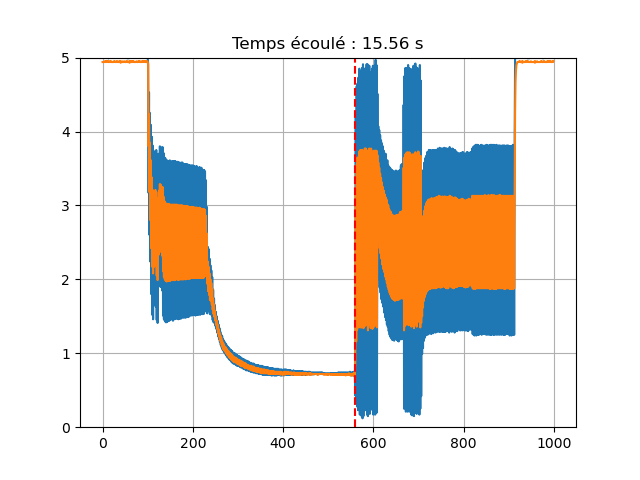

Vous avez interrompu la lecture
Fermeture du port série


In [4]:

oscillo_arduino(ser,nb_donnees,taille_bloc,nb_bloc_affich,nb_bloc_max,[y_min,y_max])


### Pour relancer la lecture il suffit de relancer la cellule ci dessus.